# Ay119: NoSQL databases: MongoDB

Prerequisites:

- `Docker`
- `python>=3.7`

In this exercise, we will:

- Set up `docker`
- Using `docker`, deploy a `MongoDB` database
- Fetch some public ZTF alerts, ingest them into the database, and create indices in the database for faster queries
- Set up `MongoDB Compass` and use it to explore the database and query it
- Query the database using python
    - Inspect the contents of an alert packet
    - Construct and plot a light curve
    - Plot the cutout images from an alert packet

## Why use MongoDB in astronomy?

There are a number of use cases in astronomy (especially in modern time-domain astronomy), where using a NoSQL database such as MongoDB is a no-brainer:

- Uses BSON (serialized binary python-dictionary-like structures) "documents" to store the data. This is natural to store alerts (AVRO directly translates into BSON) and light curves (1 read per source to extract all data points for a source)
- Giant B-tree: log(N) guaranteed for search, insert, and delete ops; blazing fast with (multiple) clever (compound) indexes and covered queries
- No schema (by default; can be enforced if need be) -> no downtime when the incoming data schema changes (e.g. the alert packet schema evolves over time)
- Built-in GeoJSON support with 2D indices on the sphere
- MongoDB Query Language (MQL): cone and general searches, aggregation pipelines
- Horizontal scale-out

## Set up

Create a persistent `docker` volume so that your data are not wiped out when you remove the container:

In [1]:
!docker volume create mongo-volume

mongo-volume


In [2]:
!docker run -d --restart always --name mongo -p 27017:27017 \
    -v mongo-volume:/data/db \
    -e MONGO_INITDB_ROOT_USERNAME=mongoadmin \
    -e MONGO_INITDB_ROOT_PASSWORD=mongoadminsecret \
    mongo:latest

b3147accfba92fbbebdc67717d1f3b714ee16e0c7f57ea0028b53b9b0ea3640e


Verify that the container is up and running:

In [3]:
!docker ps -a

CONTAINER ID        IMAGE               COMMAND                  CREATED             STATUS                  PORTS                      NAMES
b3147accfba9        mongo:latest        "docker-entrypoint.s…"   1 second ago        Up Less than a second   0.0.0.0:27017->27017/tcp   mongo


Once you are done with this exercies, to stop and remove the container, run:

In [4]:
# !docker stop mongo && docker rm -f mongo

To remove the persistent volume, run:

In [5]:
# !docker volume rm mongo-volume

### python libraries:

In [6]:
#!pip install pymongo requests matplotlib numpy pandas astropy tqdm

## Public transient alerts from the Zwicky Transient Facility

In [7]:
import pathlib
import subprocess

In [8]:
for f in ('ZTF_alerts.dump', 'ZTF_alerts_aux.dump'):
    if not pathlib.Path(f).exists():
        print(f'Fetching {f}')
        subprocess.run(['wget', f'https://storage.googleapis.com/ztf-fritz/{f}'])

Insert into two collections:

In [9]:
!docker cp ZTF_alerts.dump mongo:/tmp/
!docker cp ZTF_alerts_aux.dump mongo:/tmp/

!docker exec -it mongo \
    mongorestore -u=mongoadmin -p=mongoadminsecret --authenticationDatabase=admin \
    --archive=/tmp/ZTF_alerts.dump --drop

!docker exec -it mongo \
    mongorestore -u=mongoadmin -p=mongoadminsecret --authenticationDatabase=admin \
    --archive=/tmp/ZTF_alerts_aux.dump --drop

!docker exec -it mongo rm /tmp/ZTF_alerts.dump /tmp/ZTF_alerts_aux.dump

2020-05-03T08:49:50.250+0000	preparing collections to restore from
2020-05-03T08:49:50.267+0000	reading metadata for kowalski.ZTF_alerts from archive '/tmp/ZTF_alerts.dump'
2020-05-03T08:49:50.287+0000	restoring kowalski.ZTF_alerts from archive '/tmp/ZTF_alerts.dump'
2020-05-03T08:49:50.520+0000	restoring indexes for collection kowalski.ZTF_alerts from metadata
2020-05-03T08:49:50.915+0000	finished restoring kowalski.ZTF_alerts (313 documents, 0 failures)
2020-05-03T08:49:50.915+0000	313 document(s) restored successfully. 0 document(s) failed to restore.
2020-05-03T08:49:51.396+0000	preparing collections to restore from
2020-05-03T08:49:51.418+0000	reading metadata for kowalski.ZTF_alerts_aux from archive '/tmp/ZTF_alerts_aux.dump'
2020-05-03T08:49:51.438+0000	restoring kowalski.ZTF_alerts_aux from archive '/tmp/ZTF_alerts_aux.dump'
2020-05-03T08:49:51.501+0000	no indexes to restore
2020-05-03T08:49:51.502+0000	finished restoring kowalski.ZTF_alerts_aux (145 documents, 0 failures)
2020

Why two collections?

In [20]:
from IPython import display
import numpy as np
import pymongo
import tqdm
from utils import assemble_lc, make_dataframe, make_triplet, plot_triplet_lc

Create a user for the main database:

In [11]:
def create_user(username='ztf', password='ztfrulez', host='localhost', port=27017, verbose=True):
    _client = pymongo.MongoClient(username='mongoadmin', password='mongoadminsecret', 
                                  host=host, port=port)

    # _id: db_name.user_name
    user_ids = []
    for _u in _client.admin.system.users.find({}, {'_id': 1}):
        user_ids.append(_u['_id'])

    if verbose:
        print(user_ids)

    db_name = 'kowalski'

    _mongo = _client[db_name]

    if f'{db_name}.{username}' not in user_ids:
        _mongo.command('createUser', username, pwd=password, roles=['readWrite'])
        if verbose:
            print('Successfully initialized db')

    _mongo.client.close()

In [12]:
create_user()

['admin.mongoadmin']
Successfully initialized db


In [13]:
def connect_to_db(host='localhost', port=27017, user='ztf', password='ztfrulez'):
    _client = pymongo.MongoClient(host=host, port=port)
    # grab main database:
    _db = _client['kowalski']
    # authenticate
    _db.authenticate(user, password)
    
    return _db

In [14]:
db = connect_to_db()

In [15]:
# c = db['ZTF_alerts'].find({}, {'_id': 0, 'objectId': 1})
cursor = db['ZTF_alerts'].find({})

In [26]:
cursor = db['ZTF_alerts'].aggregate([
    {
        "$lookup": {
            "from": "ZTF_alerts_aux",
            "localField": "objectId",
            "foreignField": "_id",
            "as": "aux"
        }
    },
    {
        "$replaceRoot": {
            "newRoot": {
                "$mergeObjects": [
                    {
                        "$arrayElemAt": [
                            "$aux",
                            0
                        ]
                    },
                    "$$ROOT"
                ]
            }
        }
    },
    {
        '$sample': {
            'size': 10
        }
    }
])

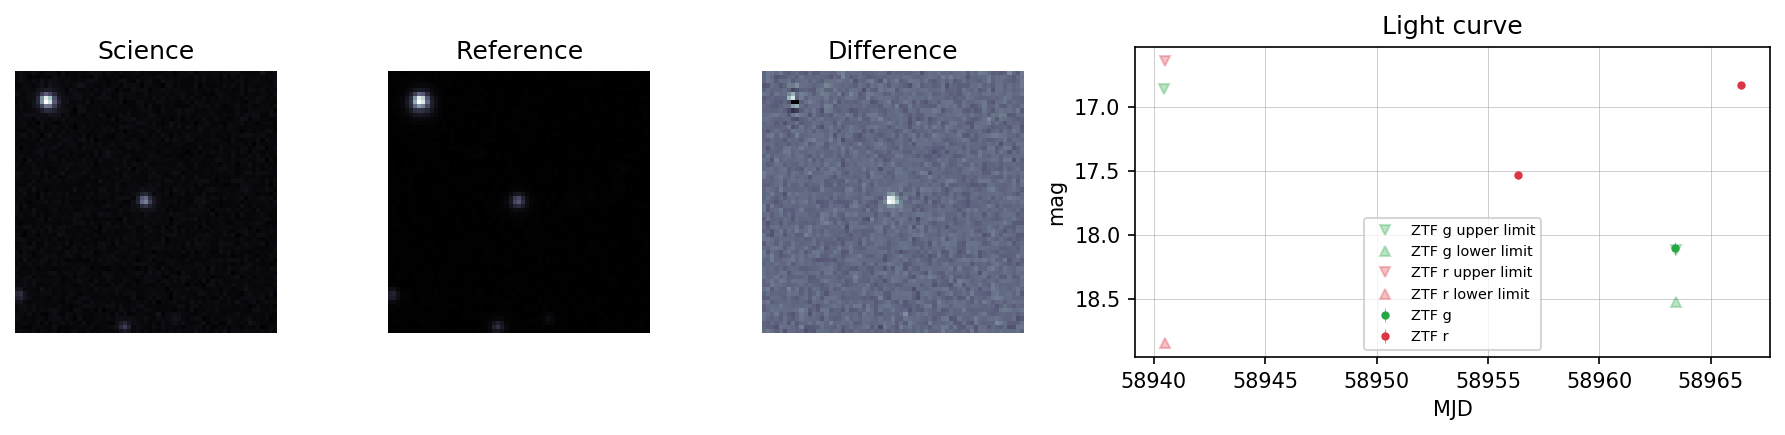

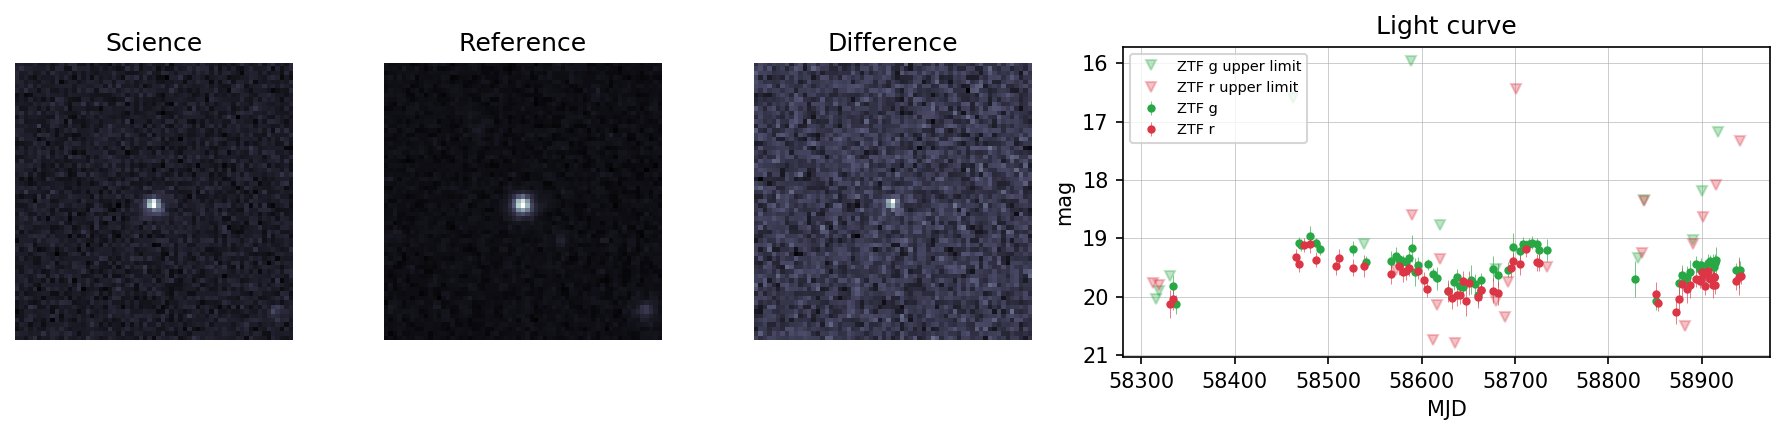

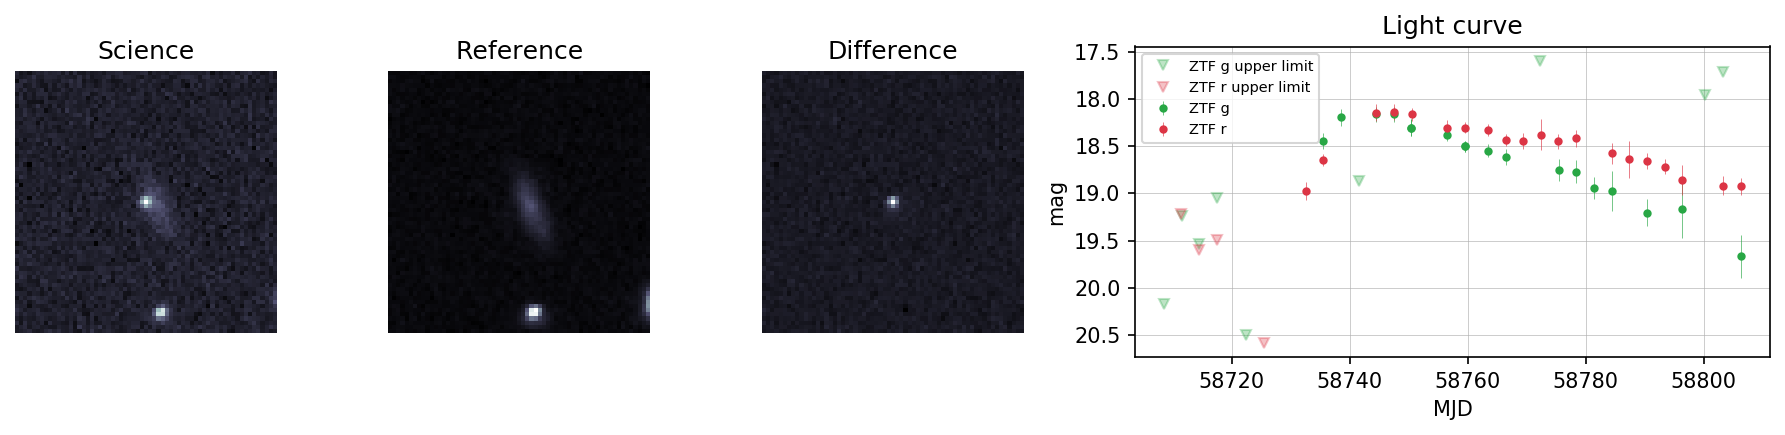

In [28]:
match_radius_arcsec = 1.5
star_galaxy_threshold = 0.4

for alert in cursor:
    display.display(
        display.HTML(
            f"<b>objectId</b>: {alert['objectId']}, "
            f"<b>candid</b>: {alert['candid']}, "
            f"<b>real/bogus score</b>: {alert['candidate'].get('drb', alert['candidate']['rb']):.3f}"
        )
    )
            
    tr = make_triplet(alert)
    
    df = make_dataframe(alert)
    
    _, lc_candid = assemble_lc(df, objectId=alert['objectId'], composite=False,
                                   match_radius_arcsec=match_radius_arcsec,
                                   star_galaxy_threshold=star_galaxy_threshold)

    plot_triplet_lc(tr, lc_candid)

### Positional queries

The `coordinates.radec_geojson` field defined for every object in our `ZTF_alerts` collection has an associated spherical 2D index, which allows for efficient positional queries. `MongoDB` supports many query operators, see [here](https://docs.mongodb.com/manual/reference/operator/query-geospatial/) for more details. The caveat to keep in mind is the following: `MongoDB` uses `GeoJSON` objects to represent `2D` positions on the sphere. Both the longitude (`R.A.`) and latitude (`Decl.`) must be expressed in decimal degrees, and the valid longitude values are between `-180` and `180`, both inclusive, so you must subtract 180.0 degrees from your `R.A.` value.

Let's define a helper function for cone searches:

In [31]:
def cone_search(_db, collection='ZTF_alerts',
                ra=0.0, dec=0.0, radius=1.0, unit='arcsec',
                projection=None):
    # cone search radius:
    cone_search_radius = float(radius)
    # convert to rad:
    if unit == 'arcsec':
        cone_search_radius *= np.pi / 180.0 / 3600.
    elif unit == 'arcmin':
        cone_search_radius *= np.pi / 180.0 / 60.
    elif unit == 'deg':
        cone_search_radius *= np.pi / 180.0
    elif unit == 'rad':
        cone_search_radius *= 1
    else:
        raise Exception('Unknown cone search unit. Must be in [deg, rad, arcsec, arcmin]')
    
    # fields to return: everything by default
    if projection is None:
        projection = dict()
    
    cursor = _db[collection].find({}, projection)
    
    cursor = db['ZTF_alerts'].aggregate([
        {
            "$match": {
                'coordinates.radec_geojson': {
                    '$geoWithin': {
                        '$centerSphere': [[ra - 180.0, dec], cone_search_radius]
                    }
                }
            }
        },
        {
            "$lookup": {
                "from": "ZTF_alerts_aux",
                "localField": "objectId",
                "foreignField": "_id",
                "as": "aux"
            }
        },
        {
            "$replaceRoot": {
                "newRoot": {
                    "$mergeObjects": [
                        {
                            "$arrayElemAt": [
                                "$aux",
                                0
                            ]
                        },
                        "$$ROOT"
                    ]
                }
            }
        }
    ])
    
    return cursor

Now let us look for some transients in [Messier 100](https://en.wikipedia.org/wiki/Messier_100):

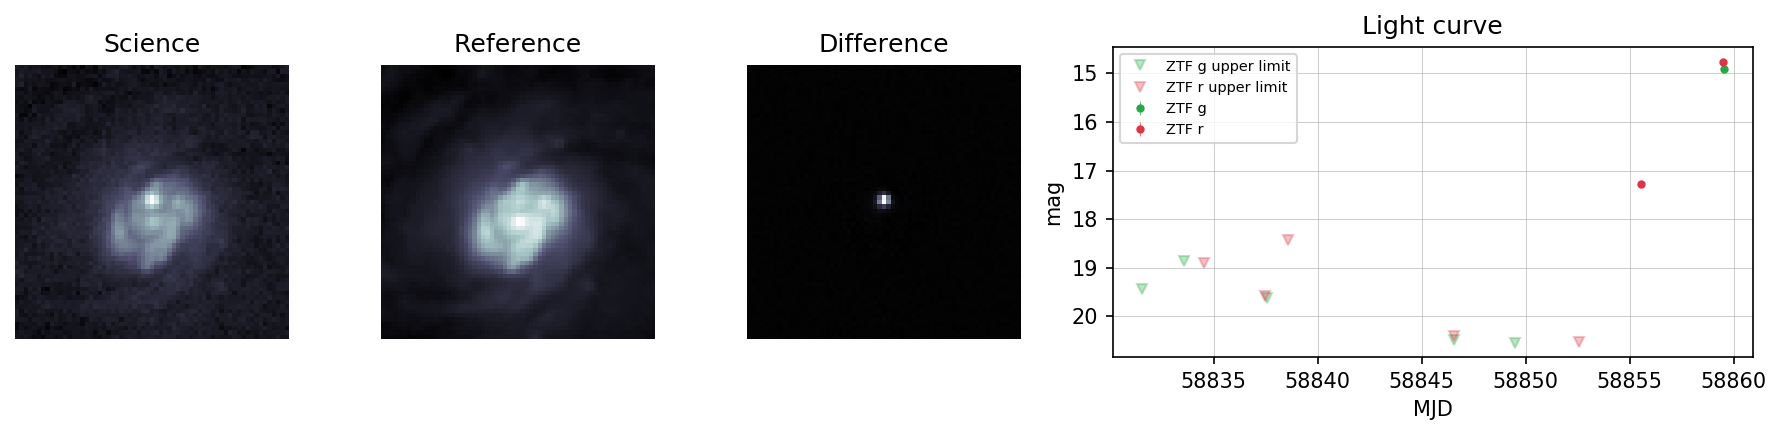

In [32]:
alerts = list(cone_search(db, ra=185.7287500, dec=15.8225000, radius=30.0, unit='arcsec',
                          projection={'_id': 0}))

for alert in alerts:
    display.display(
        display.HTML(
            f"<b>objectId</b>: {alert['objectId']}, "
            f"<b>candid</b>: {alert['candid']}, "
            f"<b>real/bogus score</b>: {alert['candidate'].get('drb', alert['candidate']['rb']):.3f}"
        )
    )
            
    tr = make_triplet(alert)
    
    df = make_dataframe(alert)
    
    _, lc_candid = assemble_lc(df, objectId=alert['objectId'], composite=False,
                                   match_radius_arcsec=match_radius_arcsec,
                                   star_galaxy_threshold=star_galaxy_threshold)

    plot_triplet_lc(tr, lc_candid)